In [1]:
import torch

from torch import nn
from torch import optim

import workspace_utils as wu

from torchvision import transforms, datasets, models

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np

## Load the data

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# The data needs to be processed and it's better to randomize
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms) 
test_data = datasets.ImageFolder(test_dir, transform=test_transforms) 

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data,batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data,batch_size=64)
testloader = torch.utils.data.DataLoader(test_data,batch_size=64)

### Label mapping

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

In [5]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:12<00:00, 19151206.38it/s]


In [6]:
# What is a criterion for choosing a good learning rate or how many nodes to have in the NN?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(9216, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(4096, 102),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [7]:
run_state = dict()

In [8]:
# Keep this workbook active during learning cycles, load the checkpoint below, if you want to use a pretrained classifier

with wu.active_session():
    epochs = 10
    steps = 0
    running_loss = 0
    print_every = 10
    
    train_losses, valid_losses = [], []
    
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        valid_loss += batch_loss.item()

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Validation loss: {valid_loss/len(testloader):.3f}.. "
                      f"Validation accuracy: {accuracy/len(testloader):.3f}")
                
                train_losses.append(running_loss/len(trainloader))
                valid_losses.append(valid_loss/len(validloader))
                
                run_state['epoch'] = epoch
                run_state['loss'] = valid_loss/len(testloader)
                
                running_loss = 0
                model.train()
                
model.class_to_idx = train_data.class_to_idx

Epoch 1/10.. Train loss: 12.397.. Validation loss: 9.567.. Validation accuracy: 0.096
Epoch 1/10.. Train loss: 5.770.. Validation loss: 3.312.. Validation accuracy: 0.292
Epoch 1/10.. Train loss: 3.129.. Validation loss: 2.466.. Validation accuracy: 0.421
Epoch 1/10.. Train loss: 2.696.. Validation loss: 1.804.. Validation accuracy: 0.557
Epoch 1/10.. Train loss: 2.092.. Validation loss: 1.482.. Validation accuracy: 0.610
Epoch 1/10.. Train loss: 1.986.. Validation loss: 1.391.. Validation accuracy: 0.634
Epoch 1/10.. Train loss: 1.710.. Validation loss: 1.262.. Validation accuracy: 0.663
Epoch 1/10.. Train loss: 1.771.. Validation loss: 1.057.. Validation accuracy: 0.724
Epoch 1/10.. Train loss: 1.521.. Validation loss: 1.095.. Validation accuracy: 0.693
Epoch 1/10.. Train loss: 1.444.. Validation loss: 0.995.. Validation accuracy: 0.727
Epoch 2/10.. Train loss: 1.452.. Validation loss: 1.032.. Validation accuracy: 0.718
Epoch 2/10.. Train loss: 1.319.. Validation loss: 1.064.. Valida

Epoch 10/10.. Train loss: 0.869.. Validation loss: 0.746.. Validation accuracy: 0.818
Epoch 10/10.. Train loss: 0.793.. Validation loss: 0.589.. Validation accuracy: 0.852
Epoch 10/10.. Train loss: 0.923.. Validation loss: 0.586.. Validation accuracy: 0.852
Epoch 10/10.. Train loss: 0.790.. Validation loss: 0.674.. Validation accuracy: 0.833
Epoch 10/10.. Train loss: 0.857.. Validation loss: 0.629.. Validation accuracy: 0.846
Epoch 10/10.. Train loss: 0.839.. Validation loss: 0.656.. Validation accuracy: 0.843


## Testing

In [15]:
test_loss = 0
accuracy = 0

model.cuda()
model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

model.cpu()

Test loss: 0.701.. Test accuracy: 0.842


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=4096, out_features=102, bias=True)
    (4): LogS

## Save the checkpoint

In [16]:
def save_model(model, optimizer, run_state):
    # Switch to CPU, since command line tool is likely to be used without GPU
    model.cpu()
    
    checkpoint = {'state_dict': model.state_dict(),
                  'classifier' : model.classifier,
                  'train_class_to_idx' : model.class_to_idx,
                  'run_state' : run_state,
                  'optim_state_dict': optimizer.state_dict()}

    torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

In [26]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    model = models.alexnet(pretrained=True)
    
    model.classifier = (checkpoint['classifier'])
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['train_class_to_idx']
    
    optimizer = optim.Adam(model.classifier.parameters())
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    
    model.cpu()
    
    return model,optimizer

# Saving / Loading

In [17]:
save_model(model,optimizer,run_state)

In [27]:
model, optimizer = load_checkpoint('checkpoint.pth')

## Image Preprocessing

In [21]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Width is shorter, shrink it to 256, otherwise shrink height
    if image.width < image.height:
        image = image.resize(( 256, round(image.height * 256/image.width)))
    else:
        image = image.resize(( round(image.width * 256/image.height), 256))
    
    
    w_cen = round(image.width/2)
    h_cen = round(image.height/2)
    
    x0 = round(w_cen-224/2)
    y0 = round(h_cen - 224/2)
    
    image = image.crop((x0,y0,x0+224,y0+224))
    
    np_image = np.array(image) / 255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = (np_image - mean) / std
    
    return np_image.transpose((2, 0, 1))

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

In [24]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    with torch.no_grad():

        model.eval()
        
        im = Image.open(image_path)
        proc_img = process_image(im)

        # forward needs a batch dimension, so we need to unsqueeze
        imgTensor = torch.from_numpy(proc_img).type(torch.FloatTensor).unsqueeze(0)
        
        top = torch.exp(model.forward(imgTensor)).topk(5)
        probs = top[0].numpy().flatten()
        classes = top[1].numpy().flatten()

        # CAVE https://dev.to/renegadecoder94/how-to-invert-a-dictionary-in-python-2150
        idx_to_class = {value: key for key, value in model.class_to_idx.items()}

        print(classes)
        print(probs)
        
        for i,c in enumerate(classes):
            classes[i] = idx_to_class[c]

        return probs, classes

## Sanity Checking

[23 91 85 25 83]
[ 0.64035505  0.2411866   0.0685564   0.01255104  0.01156579]


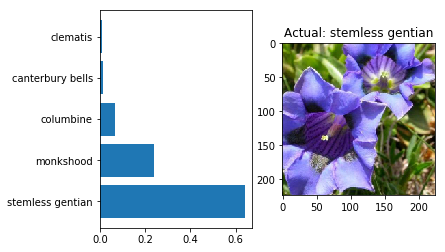

In [28]:
img = 'flowers/test/4/image_05640.jpg'
img = 'flowers/test/28/image_05230.jpg'
probs,classes = predict(img,model)

cats = []

for c in classes:
    cats.append(cat_to_name[str(c)])
    
fig, ax = plt.subplots(1,2)

y = np.arange(len(classes))

ax[0].barh(y,probs)
ax[0].set_yticks(y)
ax[0].set_yticklabels(cats)

im = Image.open(img)
imshow(torch.Tensor(process_image(im)),ax=ax[1])
ax[1].set_title('Actual: {}'.format(cat_to_name[str(img.split('/')[2])]))
plt.show()